In [1]:
import pandas as pd
import sys, os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from crimebb import *

In [3]:
from tqdm.notebook import tqdm

tqdm.pandas()

In [4]:
YEAR="2021"

In [5]:
DATA_PATH="../../data/"
CSV_PATH = f"{DATA_PATH}csv/{YEAR}/summary/"
CSV_PROCESSED = f"{DATA_PATH}csv/{YEAR}/processed/"

In [6]:
verifyDir(CSV_PROCESSED)

### Loading data

In [7]:
crimeBB_data = CrimeBBManager(DATA_PATH, YEAR)

#### Members

In [8]:
crimeBB_data.process_members()

,user_id,username,site_id
0,166130,troinik,10
1,29019,swf,10
2,33866,slesh,10
3,131527,vipnet,10
4,88822,sm3rch,10
...,...,...,...
219149,3818,Mrsirman12,20
219150,19432,Winback,20
219151,2300,a-i-c,20
219152,2279,blackhorse999,20


#### Boards

In [9]:
crimeBB_data.process_boards()

,board_id,site_id,site_name,board_title,board_url
0,24,10,forum.antichat.ru,"С/С++, C#, Delphi, .NET, Asm",https://forum.antichat.ru/forums/24/page-356
1,145,10,forum.antichat.ru,Хостинги - Hostings,https://forum.antichat.ru/forumdisplay.php?f=1...
2,150,10,forum.antichat.ru,"Мобильная связь, СМС - Покупка, продажа",https://forum.antichat.ru/forums/150/page-266
3,157,10,forum.antichat.ru,"Услуги, Покупка и Продажа в SEO",https://forum.antichat.ru/link-forums/157/page-2
4,30,10,forum.antichat.ru,Статьи,https://forum.antichat.ru/forumdisplay.php?f=3...
...,...,...,...,...,...
893,32,20,torum6uvof666pzw.onion,Networking / Wireless,http://torum6uvof666pzw.onion/viewforum.php?f=...
894,24,20,torum6uvof666pzw.onion,Website Pentesting,http://torum6uvof666pzw.onion/viewforum.php?f=...
895,29,20,torum6uvof666pzw.onion,Operating Systems,http://torum6uvof666pzw.onion/viewforum.php?f=...
896,60,20,torum6uvof666pzw.onion,Challenges,http://torum6uvof666pzw.onion/viewforum.php?f=...


#### Website

In [10]:
crimeBB_data.process_sites()

,site_id,site_name
825,2,thehub7xbw4dc5r2.onion
646,7,garage4hackers.com
0,10,forum.antichat.ru
681,12,raidforums.com
775,13,www.safeskyhacks.com
107,19,dreadditevelidot.onion
887,20,torum6uvof666pzw.onion
553,21,envoys5appps3bin.onion
64,23,germanyruvvy2tcw.onion
756,24,lwplxqzvmgu43uff.onion


#### Threads

In [11]:
crimeBB_data.process_threads()

,thread_id,site_id,board_id,user_id,username,thread_title,thread_url
0,473570,10,23,342815,dbagrov,ФСБ видит угрозу в защищённых мессенджерах и а...,https://forum.antichat.ru/threads/473570/
1,472702,10,23,335846,Dark_shadow,Эксперт Google: Вредоносные сайты атаковали по...,https://forum.antichat.ru/threads/472702/
2,473412,10,23,327300,littlebig000,Ирак полностью отключил интернет в стране,https://forum.antichat.ru/threads/473412/
3,472675,10,23,335505,Alienplan,[ВОЗМОЖНО] СОРМ расшифровывает HTTPS трафик к ...,https://forum.antichat.ru/threads/472675/
4,473059,10,23,327986,010101Hex,Обвиняемый во взломе JP Morgan Chase россиянин...,https://forum.antichat.ru/threads/473059/
...,...,...,...,...,...,...,...
405178,4450,20,62,11470,variable6754,Working dark net market places,http://torum6uvof666pzw.onion/viewtopic.php?f=...
405179,4495,20,62,10707,WrecklessRush,Need Empire market mirror link,http://torum6uvof666pzw.onion/viewtopic.php?f=...
405180,4182,20,62,10256,8634534634543,Discovering A Legitimate Online Hacking Service,http://torum6uvof666pzw.onion/viewtopic.php?f=...
405181,3848,20,62,9220,AXDZ,best market,http://torum6uvof666pzw.onion/viewtopic.php?f=...


#### Posts

In [12]:
crimeBB_data.process_posts()

,post_id,site_id,board_id,thread_id,user_id,username,user_reputation,content,post_data_creation
0,34,10,114,9,1174,Algol,0,Адрес хоть дай...Первый раз слышу о таком ...,2002-05-31 06:36:00-03
1,637,10,114,113,1174,Algol,0,Кстати этот чат ломается ...,2002-08-05 16:15:00-03
2,710,10,114,137,1174,Algol,0,Чесно говоря это действительно большая редкост...,2002-08-12 08:08:00-03
3,491,10,114,99,1548,GPT cd-r74xl 24x,0,"Сорри, этт я неправильно указал ихний адрес. И...",2002-07-19 09:30:00-03
4,571,10,46,120,1968,iRedX,9,Скоро будет обновление,2002-07-31 23:01:00-03
...,...,...,...,...,...,...,...,...,...
3373784,42116,20,49,8611,24965,tolerance2,0,What is that? I dont have javascript enabled s...,2019-08-06 21:00:00-03
3373785,42124,20,62,8454,22583,mrkcuf,0,***LINK***lovelycloud[./memberlist.php?mode=vi...,2019-08-06 21:00:00-03
3373786,42129,20,62,8454,15407,rIA,0,I wrote some keyloggers for android if you are...,2019-08-06 21:00:00-03
3373787,42134,20,62,8454,25064,lovelycloud,0,ok..,2019-08-06 21:00:00-03


### Summarizing CrimeBB

In [13]:
website_df = pd.read_csv(f"{CSV_PROCESSED}sites.csv", sep="\t", low_memory=False)
members_df = pd.read_csv(f"{CSV_PROCESSED}members.csv", sep="\t", low_memory=False)
boards_df = pd.read_csv(f"{CSV_PROCESSED}boards.csv", sep="\t", low_memory=False)
threads_df = pd.read_csv(f"{CSV_PROCESSED}threads.csv", sep="\t", low_memory=False)

In [14]:
chunk_size = 1000000

posts_reader = pd.read_csv(f"{CSV_PROCESSED}posts.csv", sep="\t", low_memory=False, iterator=True)
            
posts_df = pd.DataFrame()

len_readed=chunk_size
while len_readed>=chunk_size:
    current_df = posts_reader.get_chunk(chunk_size).copy()
    current_df.drop_duplicates(inplace=True)

    posts_df = pd.concat([posts_df, current_df], ignore_index=True)

    len_readed = current_df.shape[0]

In [15]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373789 entries, 0 to 3373788
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   post_id             int64 
 1   site_id             int64 
 2   board_id            int64 
 3   thread_id           int64 
 4   user_id             int64 
 5   username            object
 6   user_reputation     int64 
 7   content             object
 8   post_data_creation  object
dtypes: int64(6), object(3)
memory usage: 231.7+ MB


#### Merging

In [16]:
posts_threads_df = pd.merge(posts_df, threads_df[["site_id", "board_id", "thread_id", "thread_title"]].drop_duplicates(), on=["site_id", "board_id", "thread_id"], how="left")

In [17]:
posts_threads_boards_df = pd.merge(posts_threads_df, boards_df[["site_id", "site_name", "board_id", "board_title"]].drop_duplicates(), on=["site_id", "board_id"], how="left")

In [18]:
crimebb_df = posts_threads_boards_df[['post_id', 'site_id', 'board_id', 'thread_id', 'user_id', 
                                     'site_name', 'board_title', 'thread_title', 'username', 'content', 
                                     'user_reputation', 'post_data_creation']].copy()

In [19]:
crimebb_df.isnull().any()

post_id               False
site_id               False
board_id              False
thread_id             False
user_id               False
site_name             False
board_title           False
thread_title           True
username               True
content                True
user_reputation       False
post_data_creation    False
dtype: bool

In [20]:
crimebb_df

,post_id,site_id,board_id,thread_id,user_id,site_name,board_title,thread_title,username,content,user_reputation,post_data_creation
0,34,10,114,9,1174,forum.antichat.ru,Веб-уязвимости,ВЗЛОМ ФОРУМОВ,Algol,Адрес хоть дай...Первый раз слышу о таком ...,0,2002-05-31 06:36:00-03
1,637,10,114,113,1174,forum.antichat.ru,Веб-уязвимости,Есть вопрос на счёт чата,Algol,Кстати этот чат ломается ...,0,2002-08-05 16:15:00-03
2,710,10,114,137,1174,forum.antichat.ru,Веб-уязвимости,Клиенты для чата...,Algol,Чесно говоря это действительно большая редкост...,0,2002-08-12 08:08:00-03
3,491,10,114,99,1548,forum.antichat.ru,Веб-уязвимости,Всевидящее Око на http://chat.userline.ru,GPT cd-r74xl 24x,"Сорри, этт я неправильно указал ихний адрес. И...",0,2002-07-19 09:30:00-03
4,571,10,46,120,1968,forum.antichat.ru,Болталка,Зацените сайт,iRedX,Скоро будет обновление,9,2002-07-31 23:01:00-03
...,...,...,...,...,...,...,...,...,...,...,...,...
3373784,42116,20,49,8611,24965,torum6uvof666pzw.onion,General Discussions,Free stuff,tolerance2,What is that? I dont have javascript enabled s...,0,2019-08-06 21:00:00-03
3373785,42124,20,62,8454,22583,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER,mrkcuf,***LINK***lovelycloud[./memberlist.php?mode=vi...,0,2019-08-06 21:00:00-03
3373786,42129,20,62,8454,15407,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER,rIA,I wrote some keyloggers for android if you are...,0,2019-08-06 21:00:00-03
3373787,42134,20,62,8454,25064,torum6uvof666pzw.onion,Marketplace Discussions,KEYLOGGER,lovelycloud,ok..,0,2019-08-06 21:00:00-03


In [21]:
crimebb_df.to_csv(f"{CSV_PROCESSED}crimeBB_{YEAR}.csv", sep='\t', index=False)

### Drawing Missing Values

#### user_id equals None

In [22]:
none_members_users = members_df[ (members_df["username"].str.lower()=="none") | (members_df["username"].isna()) ].copy().drop_duplicates()

In [23]:
none_threads_users = threads_df[ (threads_df["username"].str.lower()=="none") | (threads_df["username"].isna()) ].copy().drop_duplicates()

In [24]:
none_posts_users = posts_df[ (posts_df["username"].str.lower()=="none") | (posts_df["username"].isna()) ].copy().drop_duplicates()

#### thread title None

In [25]:
none_threads_title = threads_df[threads_df["thread_title"].isna()]

In [26]:
none_posts_threads_title = posts_threads_df[posts_threads_df["thread_title"].isna()]

#### posts content None

In [27]:
none_posts_content = posts_threads_df[posts_threads_df["content"].isna()]

#### Draw

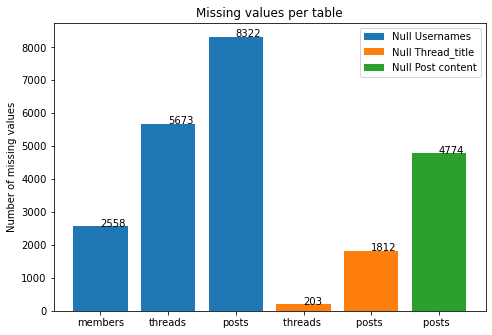

In [28]:
import matplotlib.pyplot as plt

# None usernames

legends_users = ["members", "threads", "posts"]
values_users = [len(none_members_users), len(none_threads_users), len(none_posts_users)]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(legends_users,values_users, label='Null Usernames')
for x,y,p in zip(legends_users, values_users, values_users):
  plt.text(x, y, p)

# None threads title

legends_threads = ["threads ", "posts "]
values_threads = [len(none_threads_title), len(none_posts_threads_title)]

ax.bar(legends_threads, values_threads, label='Null Thread_title')
for x,y,p in zip(legends_threads, values_threads, values_threads):
  plt.text(x, y, p)

# None posts content

legends_posts = ["posts  "]
values_posts = [len(none_posts_content)]

ax.bar(legends_posts, [len(none_posts_content)], label='Null Post content')
for x,y,p in zip(legends_posts, values_posts, values_posts):
  plt.text(x, y, p)

ax.legend()
ax.set_title("Missing values per table")
ax.set_ylabel("Number of missing values")
plt.show()